In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 88.0 MB/s eta 0:00:00


In [ ]:
!pip install rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import string
import nltk
import cv2
from glob import glob

import multiprocessing
import warnings

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import cosine_distances
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
from gensim.models.doc2vec  import Doc2Vec, TaggedDocument

from wordcloud import WordCloud

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from rouge import Rouge

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# Частина №1

# Підготовчий етап

## Провести аналіз вибраного набору даних, визначити вхідні та вихідні параметри, візуалізувати залежності входів на виходу, спробувати виявити основні залежності, детектувати аномалії, неповні зразки тощо у даних.

## Preparing dataset

In [ ]:
bad=pd.read_csv('/content/drive/MyDrive/data/clickbait_data',on_bad_lines='skip',header=None)
good=pd.read_csv('/content/drive/MyDrive/data/non_clickbait_data',on_bad_lines='skip',header=None)
bad.columns=['text']
good.columns=['text']
good['clickbait']=0
bad['clickbait']=1
df=pd.concat([bad,good],ignore_index=True).sample(frac = 1).reset_index().drop('index',axis=1)
df.head(3)

,text,clickbait
0,18 Presentations That Would Make You Pay Atten...,1
1,Here's How To Make Pumpkin Spice Mini Cookie Pies,1
2,This Louisiana Sheriff Will Scare The Living S...,1


In [ ]:
df.clickbait.value_counts()

1    15303
0    12907
Name: clickbait, dtype: int64

In [ ]:
df.isna().sum()

text         0
clickbait    0
dtype: int64

In [ ]:
def clean_text(text):
    text = text.lower()  # Convert text to lower case
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation marks
    text = word_tokenize(text)  # Break the text into tokens
    stop_words = set(stopwords.words('english'))  
    text = [word for word in text if word not in stop_words]  # Remove stop-words
    lemmatizer = WordNetLemmatizer()  
    text = [lemmatizer.lemmatize(word) for word in text]  # lemmatization of the text
    text = " ".join(text)  # Connect the tokens in a line
    return text

In [ ]:
df['text'] = df['text'].apply(lambda x: clean_text(x) if type(x) == str else x) # performing text cleanup on each line

### data visualization

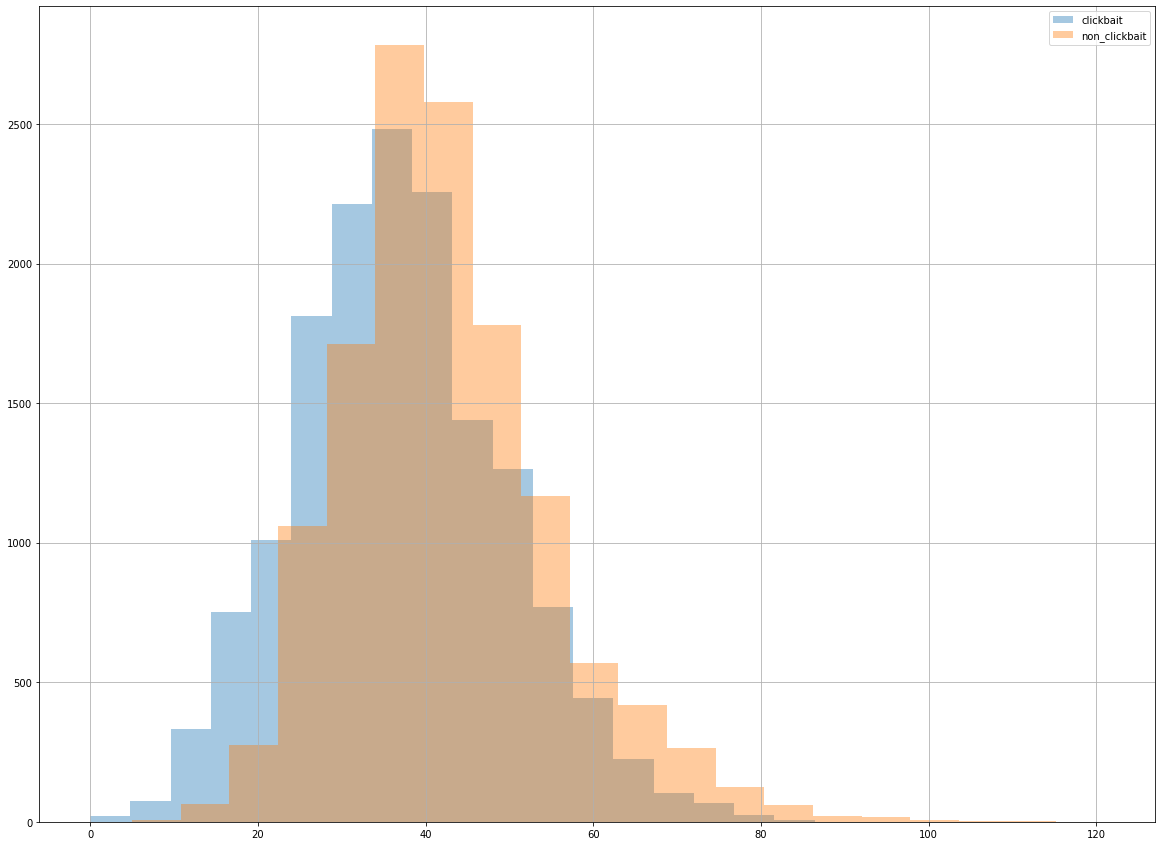

In [ ]:
plt.figure(figsize=(20,15))
plt.hist(df[df['clickbait']==1]['text'].str.len(), bins=20, label='clickbait',alpha=0.4)
plt.hist(df[df['clickbait']==0]['text'].str.len(), bins=20, label='non_clickbait',alpha=0.4)
plt.grid()
plt.legend()
plt.show()

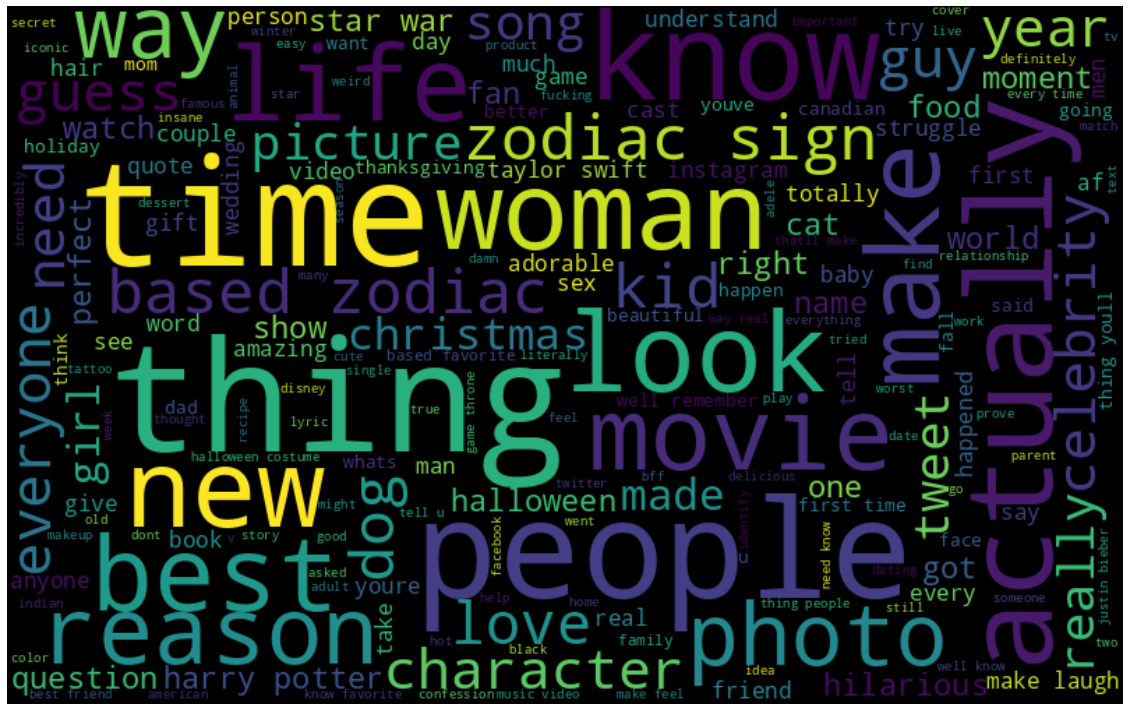

In [ ]:
all_words = ' '.join([text for text in df[df['clickbait']==1]['text']]) 

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 
plt.figure(figsize=(20, 15)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off')
plt.show()

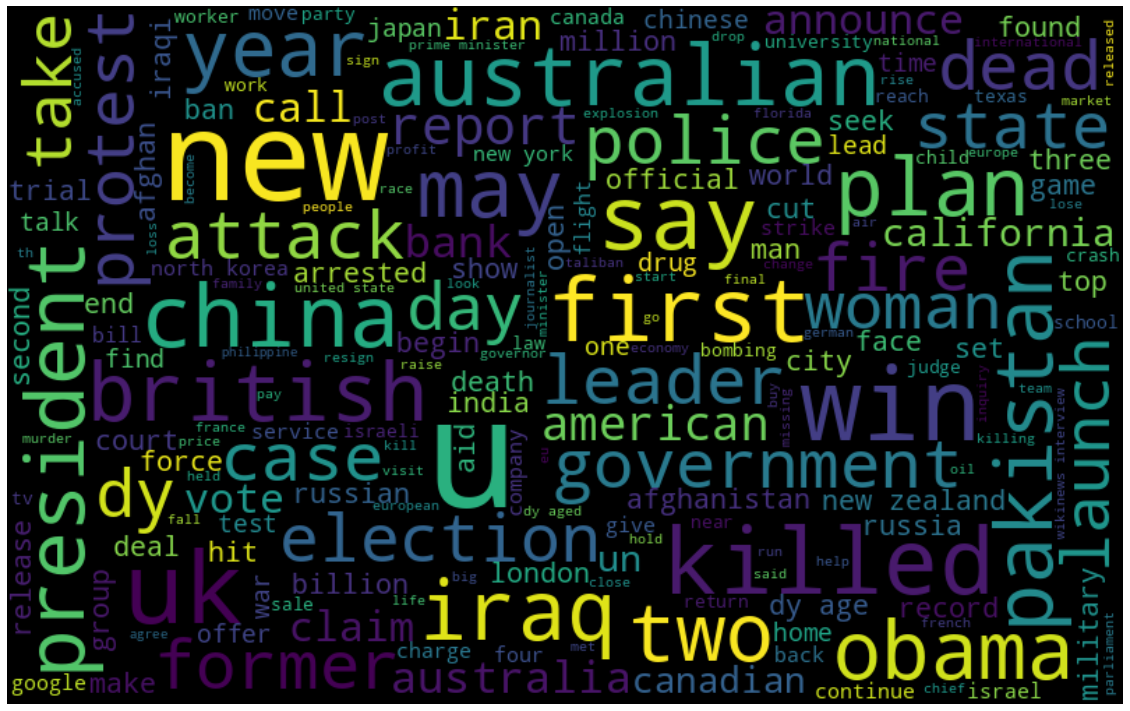

In [ ]:
all_words = ' '.join([text for text in df[df['clickbait']==0]['text']]) 

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 
plt.figure(figsize=(20, 15)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off')
plt.show()

In [ ]:
# neighbor search algorithm
def neighbor_search(word,vectorizer,matrix, n):
  word_index = vectorizer.vocabulary_.get(word) #find the index of the word
  dist = cosine_distances(matrix.T[word_index], matrix.T) #calculate the cosine distance from a word to other words
  dist_indices = dist.argsort()[0][1:n+1]
  return sorted([(vectorizer.get_feature_names_out()[i],dist[0][i]) for i in dist_indices],key=lambda x: x[1])

# cross-one-out algorithm
def cross_one_out(words,vectorizer,matrix):
  word_indices = [vectorizer.vocabulary_.get(w) for w in words] #find the indexes of the words
  word_distances = cosine_similarity(matrix.T[word_indices], matrix.T) #calculate the cosine distance from a words to other words
  avg_distances = word_distances.mean(axis=0) 
  idx = avg_distances.argmax()

  return vectorizer.get_feature_names_out()[idx]

# Використати алгоритми/моделі tf-idf, BoW, Word2Vec, Doc2Vec для feature extraction.

## Проаналізувати результати ембедингів за допомогою cross-one-out та пошуком сусідів.

### TF-IDF

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(df['text'])
tfidf_matrix=tfidf_vectorizer.transform(df['text'])
words = tfidf_vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=words)

In [ ]:
neighbor_search('world',tfidf_vectorizer,tfidf_matrix,10)

[('around', 0.7918765568776334),
 ('cup', 0.8001231397094479),
 ('championship', 0.8346531143733654),
 ('fifa', 0.8396535677102078),
 ('qualifier', 0.8954763471963534),
 ('twenty', 0.9130607311374093),
 ('oldest', 0.914747507349514),
 ('netball', 0.923547433421428),
 ('jurassic', 0.926055097337847),
 ('deaf', 0.9304733801228944)]

In [ ]:
cross_one_out(['cup','fifa','championship','qualifier'],tfidf_vectorizer,tfidf_matrix)

'cup'

### BoW

In [ ]:
bow_vectorizer = CountVectorizer()
bow_vectorizer.fit(df['text'])
bow_matrix = bow_vectorizer.transform(df['text'])
bow_words = bow_vectorizer.get_feature_names_out()

bow_df = pd.DataFrame(bow_matrix.toarray(), columns=bow_words)

In [ ]:
neighbor_search('world',bow_vectorizer,bow_matrix,10)

[('cup', 0.7872466956495814),
 ('fifa', 0.8194551694945484),
 ('around', 0.8195112430506422),
 ('championship', 0.8249003672248577),
 ('qualifier', 0.8870334911742829),
 ('deaf', 0.8983185206522395),
 ('swimming', 0.9119412557904567),
 ('netball', 0.9137204037185424),
 ('oldest', 0.9178118387377595),
 ('twenty', 0.9240350512565817)]

In [ ]:
cross_one_out(['cup','fifa','championship','qualifier'],bow_vectorizer,bow_matrix)

'cup'

### Word2Vec

In [ ]:
sent = [row.split() for row in df['text']]

phrases = Phrases(sent, min_count=30, progress_per=10000)
bigram = Phraser(phrases)
sentences = bigram[sent]

cores = multiprocessing.cpu_count() 

w2v_model = Word2Vec(min_count=20,
                     window=2,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

w2v_model.build_vocab(sentences, progress_per=10000)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
w2v_model.init_sims(replace=True)

In [ ]:
w2v_model.wv.most_similar(positive=["world"])

[('pro', 0.9935945272445679),
 ('next', 0.9934459924697876),
 ('event', 0.9918259978294373),
 ('bull', 0.9917723536491394),
 ('master', 0.9917685985565186),
 ('chance', 0.991668701171875),
 ('series', 0.9914668798446655),
 ('goal', 0.9913806915283203),
 ('title', 0.9912618398666382),
 ('miss', 0.9912122488021851)]

In [ ]:
w2v_model.wv.doesnt_match(['cup','fifa','championship','qualifier'])

'fifa'

### Doc2Vec

In [ ]:
sent = [row.split() for row in df['text']]

tagged_data = [TaggedDocument(words=sent[i], tags=[str(i)]) for i in range(len(sent))]
model_d2v = Doc2Vec(tagged_data,dm=1, # dm = 1 for ‘distributed memory’ model
                                  dm_mean=1, # dm_mean = 1 for using mean of the context word vectors
                                  vector_size=200, # no. of desired features
                                  window=2, # width of the context window                                  
                                  negative=7, # if > 0 then negative sampling will be used
                                  min_count=5, # Ignores all words with total frequency lower than 5.                                                                   
                                  alpha=0.1, # learning rate                                  
                                  seed = 23, # for reproducibility
                                 ) 

In [ ]:
model_d2v.init_sims(replace=True)
model_d2v.wv.most_similar(positive=["world"])

[('asian', 0.538987934589386),
 ('cycling', 0.5384952425956726),
 ('scotland', 0.518544614315033),
 ('america', 0.4913581311702728),
 ('tyra', 0.478261262178421),
 ('nervous', 0.4755188226699829),
 ('stanley', 0.46399980783462524),
 ('heist', 0.44279012084007263),
 ('event', 0.4304822087287903),
 ('uefa', 0.4182073771953583)]

In [ ]:
model_d2v.wv.doesnt_match(['cup','fifa','championship','qualifier'])

'qualifier'

# Використати summarization модель, використовуючи word embedding tokenizers

## Використати метрики оцінки summarization та обгрунтувати їх використання (чому ці доречні, а інші - ні).

In [ ]:
ref = """ Videos that say approved vaccines are dangerous and cause autism, cancer or infertility are among those that will be taken down, the company said.  The policy includes the termination of accounts of anti-vaccine influencers.  Tech giants have been criticised for not doing more to counter false health information on their sites.  In July, US President Joe Biden said social media platforms were largely responsible for people's scepticism in getting vaccinated by spreading misinformation, and appealed for them to address the issue.  YouTube, which is owned by Google, said 130,000 videos were removed from its platform since last year, when it implemented a ban on content spreading misinformation about Covid vaccines.  In a blog post, the company said it had seen false claims about Covid jabs "spill over into misinformation about vaccines in general". The new policy covers long-approved vaccines, such as those against measles or hepatitis B.  "We're expanding our medical misinformation policies on YouTube with new guidelines on currently administered vaccines that are approved and confirmed to be safe and effective by local health authorities and the WHO," the post said, referring to the World Health Organization.
"""

In [ ]:
orig_sum="""Videos that say approved vaccines are dangerous and cause autism, cancer or infertility are among those that will be taken down. The policy includes the termination of accounts of anti-vaccine influencers. YouTube, which is owned by Google, said 130,000 videos were removed from its platform since last year. """

In [ ]:
# Load the pre-trained tokenizer and model
tokenizer1 = AutoTokenizer.from_pretrained("t5-base")
model1 = AutoModelForSeq2SeqLM.from_pretrained("t5-base")

input_ids1 = tokenizer1.encode(ref, return_tensors="pt")

summary_ids1 = model1.generate(input_ids1, num_beams=4, max_length=250, early_stopping=True)
summary1 = tokenizer1.decode(summary_ids1[0], skip_special_tokens=True)

print(summary1)

videos that say approved vaccines are dangerous and cause autism, cancer or infertility are among those that will be taken down, the company said. the policy includes the termination of accounts of anti-vaccine influencers.


In [ ]:
tokenizer2 = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")
model2 = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn")

input_ids2 = tokenizer2.encode(ref, return_tensors="pt")

summary_ids2 = model2.generate(input_ids2, num_beams=4, max_length=200, early_stopping=True)
summary2 = tokenizer2.decode(summary_ids2[0], skip_special_tokens=True)

print(summary2)

Videos that say approved vaccines are dangerous and cause autism, cancer or infertility are among those that will be taken down. The policy includes the termination of accounts of anti-vaccine influencers. YouTube, which is owned by Google, said 130,000 videos were removed from its platform since last year.


In [ ]:
rouge = Rouge()

scores1 = rouge.get_scores(summary1, orig_sum)
scores2 = rouge.get_scores(summary2, orig_sum)

In [ ]:
pd.DataFrame(scores1[0])

,rouge-1,rouge-2,rouge-l
r,0.586957,0.541667,0.565217
p,0.931034,0.787879,0.896552
f,0.720000,0.641975,0.693333


In [ ]:
pd.DataFrame(scores2[0])

,rouge-1,rouge-2,rouge-l
r,0.978261,0.979167,0.978261
p,1.000000,1.000000,1.000000
f,0.989011,0.989474,0.989011
